 1- New extension available. ".parquet" extension files are now available to download. These files will be much quicker to download and take less space in the ram (about 50% less ram by using the parquet files). - @xgilbert proposal
 
2- Feature names are ranging from Feature_1 to Feature_n. They are prefixed with their respective strategy.

3- - The X_test dataframe now includes the id and moon columns - @emanuele proposal. You will have to submit it with these columns. This will allow the system to check the integrity of your submission.

4- The CrunchDAO investment universe has been considerably reduced in this master dataset. This is mainly for increasing the capacity of the strategy, focusing on significant US volume and market capitalization, avoiding SPACs and industries out of our investment scope.

5- The number of bins changed from 5 to 7 in a non-uniform distribution. The features bins follow a Gaussian distribution  whereas the target ones are fat-tailed (non-zero kurtosis). 

6- target_w (7 days idiosyncratic target) is added to the targets.

7- Data is now computed on the last trading day of the week rather than on Wednesday.

8- Targets start capturing the specific two days after the features date in order to align with the trading reality.

9- Moons are now continuous between train set and test set. - @markodarko proposal

# QuickStarter to the tournament

## Basic step and workflow:

0 - Using this notebook

1 - Download data

2 - Explore data

3 - Choose and train a model

4 - Scoring

5 - Train / test split

6 - Make prediction

7 - Submit

# 0 - Using this notebook 

To execute the cell press `shift+enter`. 

Follow the steps and login with your Google account.

In [6]:
# Lib & Dependencies
import pandas as pd
import numpy as np
import xgboost as xgb
import scipy

import seaborn as sns
import matplotlib.pyplot as plt

import requests
import gc

# 1 - Download data

Each week we will provide you with four DataFrames:

- X_train contains the features.
- y_train contains the targets. 
- X_test contains the features you can use in your models.
- exemple_prediction contains an example of the submission awaited.

There are 4 targets you need to predict: target_w, target_r, target_g, and target_b.

You can either download the data in the .csv or .parquet extension.
The .csv will be longer to download and take up more space in the ram.

In [7]:
# Data Download (may take a few minutes depending on your network)

# Chose a file format between parquet and csv
file_format = 'parquet'

train_datalink_X = f'https://tournament.crunchdao.com/data/master/X_train_one_dataset.{file_format}' 
train_datalink_y = f'https://tournament.crunchdao.com/data/master/y_train_one_dataset.{file_format}'
test_datalink_X = f'https://tournament.crunchdao.com/data/master/X_test_one_dataset.{file_format}'
exemple_submission_datalink = f'https://tournament.crunchdao.com/data/master/example_submission_one_dataset.{file_format}' 

if file_format == 'parquet':
  # Data for training
  train_features = pd.read_parquet(train_datalink_X)
  # Data for which you will submit your prediction
  test_data = pd.read_parquet(test_datalink_X)
  # Targets use for your supervised trainning
  train_targets = pd.read_parquet(train_datalink_y)
  # Exemple of an awaited submission
  exemple_submission = pd.read_parquet(exemple_submission_datalink)
elif file_format == 'csv':
  # Data for training
  train_features = pd.read_csv(train_datalink_X)
  # Data for which you will submit your prediction
  test_data = pd.read_csv(test_datalink_X)
  # Targets use for your supervised trainning
  train_targets = pd.read_csv(train_datalink_y)
  # Exemple of an awaited submission
  exemple_submission = pd.read_csv(exemple_submission_datalink)

In [10]:
train_features

,id,Moons,brisk_Feature_1,brisk_Feature_2,brisk_Feature_3,brisk_Feature_4,brisk_Feature_5,brisk_Feature_6,brisk_Feature_9,brisk_Feature_10,...,vratios_Feature_204,vratios_Feature_242,vratios_Feature_261,vratios_Feature_263,vratios_Feature_264,vratios_Feature_265,vratios_Feature_266,vratios_Feature_267,vratios_Feature_268,vratios_Feature_269
0,132931,0,0.50,0.67,0.83,0.83,0.50,0.67,0.00,0.50,...,1.00,1.00,0.83,0.67,0.67,0.67,0.50,0.17,0.67,0.17
1,275489,0,0.83,0.33,0.67,0.83,0.67,1.00,0.50,0.50,...,0.00,0.50,0.50,0.00,0.33,1.00,0.17,0.00,0.00,0.33
2,221654,0,0.17,1.00,0.50,0.50,0.50,0.33,0.17,0.50,...,0.17,0.00,0.17,0.50,0.67,0.67,0.50,0.17,0.67,0.17
3,201744,0,0.67,0.17,0.50,0.50,0.67,0.33,0.33,0.67,...,0.50,0.50,0.17,0.33,0.33,0.50,0.50,0.50,0.17,0.00
4,291075,0,0.50,0.50,0.17,0.50,0.50,0.17,0.33,0.50,...,0.33,0.83,0.17,0.50,0.50,0.67,0.33,0.33,0.67,0.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182794,235802,209,0.33,0.17,0.67,0.50,0.50,0.67,0.33,0.50,...,0.50,0.17,0.83,0.50,0.50,0.17,0.50,0.83,0.67,0.50
182795,13596,209,0.67,0.33,0.17,0.83,0.33,0.17,0.33,0.50,...,0.50,0.67,0.33,0.17,0.33,0.50,0.17,0.50,0.50,0.83
182796,92471,209,0.17,0.67,0.33,0.83,0.50,0.50,0.17,0.33,...,0.50,0.67,0.33,0.17,0.17,0.17,0.33,0.50,0.67,0.33
182797,217860,209,0.83,0.00,0.33,0.67,0.67,0.33,0.67,0.17,...,0.83,0.67,0.50,0.50,0.83,0.83,0.00,0.83,1.00,0.50


In [11]:
test_data

,id,Moons,brisk_Feature_1,brisk_Feature_2,brisk_Feature_3,brisk_Feature_4,brisk_Feature_5,brisk_Feature_6,brisk_Feature_9,brisk_Feature_10,...,vratios_Feature_204,vratios_Feature_242,vratios_Feature_261,vratios_Feature_263,vratios_Feature_264,vratios_Feature_265,vratios_Feature_266,vratios_Feature_267,vratios_Feature_268,vratios_Feature_269
0,118511,210,0.67,0.83,0.83,0.33,0.17,0.67,0.33,0.33,...,0.33,0.67,0.67,0.50,0.50,0.50,0.50,0.33,0.50,0.50
1,119661,210,0.67,0.33,0.83,0.83,1.00,0.17,0.83,0.67,...,0.17,0.83,0.33,0.50,0.83,0.17,0.67,0.50,0.17,0.33
2,71986,210,0.67,0.33,0.50,0.50,0.33,0.50,0.17,0.17,...,0.83,0.50,0.33,0.50,0.33,0.50,0.67,0.67,0.33,0.50
3,195408,210,0.33,0.33,0.50,0.50,0.50,0.33,0.50,0.50,...,0.50,0.17,0.50,0.50,0.50,0.50,0.67,0.50,0.67,0.50
4,12123,210,0.17,0.17,0.67,0.50,0.17,0.83,0.50,0.00,...,0.67,0.67,0.33,0.67,0.17,0.50,0.17,0.50,0.50,0.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131087,58450,366,0.83,0.17,0.50,0.83,0.67,0.50,0.33,0.67,...,0.67,0.67,0.67,0.33,0.50,0.33,0.50,0.67,0.50,0.17
131088,182239,366,0.33,0.17,0.33,0.33,0.33,0.67,0.83,0.83,...,0.67,0.33,0.33,0.67,0.83,0.67,0.50,0.17,0.50,0.17
131089,108004,366,0.33,0.50,0.33,0.50,0.67,0.33,0.50,0.33,...,0.50,0.67,0.50,0.50,0.50,0.50,0.67,0.67,0.50,0.33
131090,290465,366,0.50,0.67,0.50,0.67,0.67,0.50,0.33,0.17,...,0.50,0.50,0.50,0.50,0.50,0.50,0.17,0.83,1.00,0.33


In [12]:
# Merge train_features and train_targets for ease of use
train_data = pd.merge(train_features, train_targets, on=['id', 'Moons'], how='inner')

del train_features, train_targets
gc.collect()

0

In [13]:
train_data.head()

,id,Moons,brisk_Feature_1,brisk_Feature_2,brisk_Feature_3,brisk_Feature_4,brisk_Feature_5,brisk_Feature_6,brisk_Feature_9,brisk_Feature_10,...,vratios_Feature_264,vratios_Feature_265,vratios_Feature_266,vratios_Feature_267,vratios_Feature_268,vratios_Feature_269,target_w,target_r,target_g,target_b
0,132931,0,0.50,0.67,0.83,0.83,0.50,0.67,0.00,0.50,...,0.67,0.67,0.50,0.17,0.67,0.17,0.50,0.50,0.33,0.50
1,275489,0,0.83,0.33,0.67,0.83,0.67,1.00,0.50,0.50,...,0.33,1.00,0.17,0.00,0.00,0.33,0.17,0.00,0.00,0.33
2,221654,0,0.17,1.00,0.50,0.50,0.50,0.33,0.17,0.50,...,0.67,0.67,0.50,0.17,0.67,0.17,0.50,0.50,0.50,0.50
3,201744,0,0.67,0.17,0.50,0.50,0.67,0.33,0.33,0.67,...,0.33,0.50,0.50,0.50,0.17,0.00,0.67,0.67,0.67,0.67
4,291075,0,0.50,0.50,0.17,0.50,0.50,0.17,0.33,0.50,...,0.50,0.67,0.33,0.33,0.67,0.50,0.50,0.50,0.50,0.33


In [14]:
# Get the features columns name  and the targets columns name
features = [col for col in train_data.columns if 'Feature' in col]
targets = [col for col in train_data.columns if 'target' in col]

In [15]:
display(train_data.head())
display(test_data.head())

,id,Moons,brisk_Feature_1,brisk_Feature_2,brisk_Feature_3,brisk_Feature_4,brisk_Feature_5,brisk_Feature_6,brisk_Feature_9,brisk_Feature_10,...,vratios_Feature_264,vratios_Feature_265,vratios_Feature_266,vratios_Feature_267,vratios_Feature_268,vratios_Feature_269,target_w,target_r,target_g,target_b
0,132931,0,0.50,0.67,0.83,0.83,0.50,0.67,0.00,0.50,...,0.67,0.67,0.50,0.17,0.67,0.17,0.50,0.50,0.33,0.50
1,275489,0,0.83,0.33,0.67,0.83,0.67,1.00,0.50,0.50,...,0.33,1.00,0.17,0.00,0.00,0.33,0.17,0.00,0.00,0.33
2,221654,0,0.17,1.00,0.50,0.50,0.50,0.33,0.17,0.50,...,0.67,0.67,0.50,0.17,0.67,0.17,0.50,0.50,0.50,0.50
3,201744,0,0.67,0.17,0.50,0.50,0.67,0.33,0.33,0.67,...,0.33,0.50,0.50,0.50,0.17,0.00,0.67,0.67,0.67,0.67
4,291075,0,0.50,0.50,0.17,0.50,0.50,0.17,0.33,0.50,...,0.50,0.67,0.33,0.33,0.67,0.50,0.50,0.50,0.50,0.33


,id,Moons,brisk_Feature_1,brisk_Feature_2,brisk_Feature_3,brisk_Feature_4,brisk_Feature_5,brisk_Feature_6,brisk_Feature_9,brisk_Feature_10,...,vratios_Feature_204,vratios_Feature_242,vratios_Feature_261,vratios_Feature_263,vratios_Feature_264,vratios_Feature_265,vratios_Feature_266,vratios_Feature_267,vratios_Feature_268,vratios_Feature_269
0,118511,210,0.67,0.83,0.83,0.33,0.17,0.67,0.33,0.33,...,0.33,0.67,0.67,0.50,0.50,0.50,0.50,0.33,0.50,0.50
1,119661,210,0.67,0.33,0.83,0.83,1.00,0.17,0.83,0.67,...,0.17,0.83,0.33,0.50,0.83,0.17,0.67,0.50,0.17,0.33
2,71986,210,0.67,0.33,0.50,0.50,0.33,0.50,0.17,0.17,...,0.83,0.50,0.33,0.50,0.33,0.50,0.67,0.67,0.33,0.50
3,195408,210,0.33,0.33,0.50,0.50,0.50,0.33,0.50,0.50,...,0.50,0.17,0.50,0.50,0.50,0.50,0.67,0.50,0.67,0.50
4,12123,210,0.17,0.17,0.67,0.50,0.17,0.83,0.50,0.00,...,0.67,0.67,0.33,0.67,0.17,0.50,0.17,0.50,0.50,0.33


# 2 - Explore Data

Observe your data and prepare carefully what you will give to your model for training.

In [16]:
display(train_data.describe())

,id,Moons,brisk_Feature_1,brisk_Feature_2,brisk_Feature_3,brisk_Feature_4,brisk_Feature_5,brisk_Feature_6,brisk_Feature_9,brisk_Feature_10,...,vratios_Feature_264,vratios_Feature_265,vratios_Feature_266,vratios_Feature_267,vratios_Feature_268,vratios_Feature_269,target_w,target_r,target_g,target_b
count,182799.000000,182799.000000,182799.000000,182799.000000,182799.000000,182799.000000,182799.000000,182799.000000,182799.000000,182799.000000,...,182799.000000,182799.000000,182799.000000,182799.000000,182799.000000,182799.000000,182799.000000,182799.000000,182799.000000,182799.000000
mean,157100.959152,104.080646,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,...,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500004,0.500002,0.500016,0.500000
std,90700.933667,60.378992,0.232211,0.232211,0.232211,0.232211,0.232211,0.232211,0.232211,0.232211,...,0.232211,0.232211,0.232211,0.232211,0.232211,0.232211,0.117296,0.188226,0.188391,0.183523
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,78680.500000,52.000000,0.330000,0.330000,0.330000,0.330000,0.330000,0.330000,0.330000,0.330000,...,0.330000,0.330000,0.330000,0.330000,0.330000,0.330000,0.500000,0.330000,0.330000,0.330000
50%,157117.000000,104.000000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,...,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
75%,235879.500000,156.000000,0.670000,0.670000,0.670000,0.670000,0.670000,0.670000,0.670000,0.670000,...,0.670000,0.670000,0.670000,0.670000,0.670000,0.670000,0.500000,0.670000,0.670000,0.670000
max,313890.000000,209.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## 2.1 - Correlation matrix

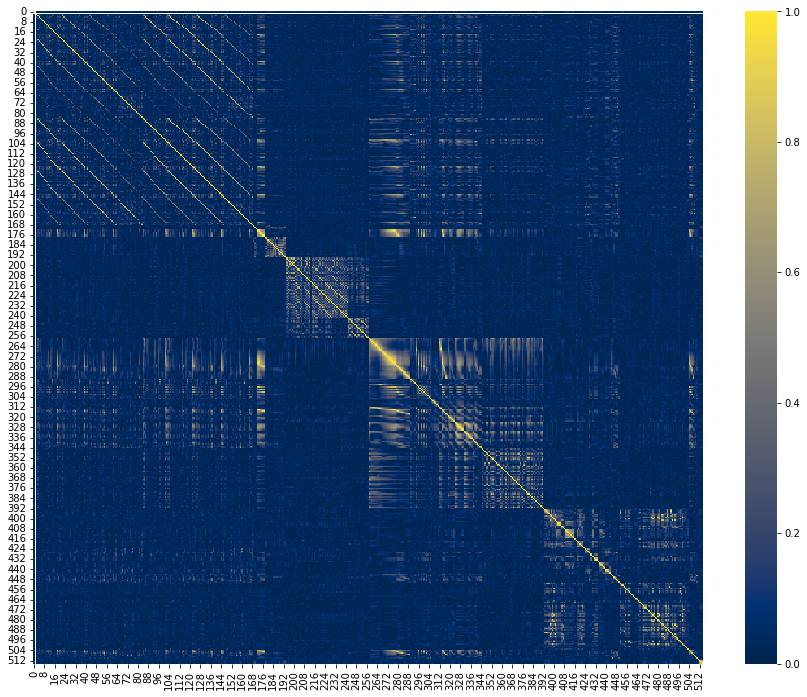

In [17]:
def show_cov(x):
    cov = x.corr().abs().to_numpy()
    plt.figure(figsize=(15, 12))
    sns.heatmap(cov,vmin=0, vmax=1, cmap="cividis")
    plt.show()

train_data_last = train_data[train_data['Moons'] == train_data['Moons'].max()]
show_cov(train_data_last)

## 2.2 - Data distribution 

For the rational behind the feature engineering of the dataset see the paper below:

https://desci.crunchdao.com/projects/crunchdao/feature-engineering

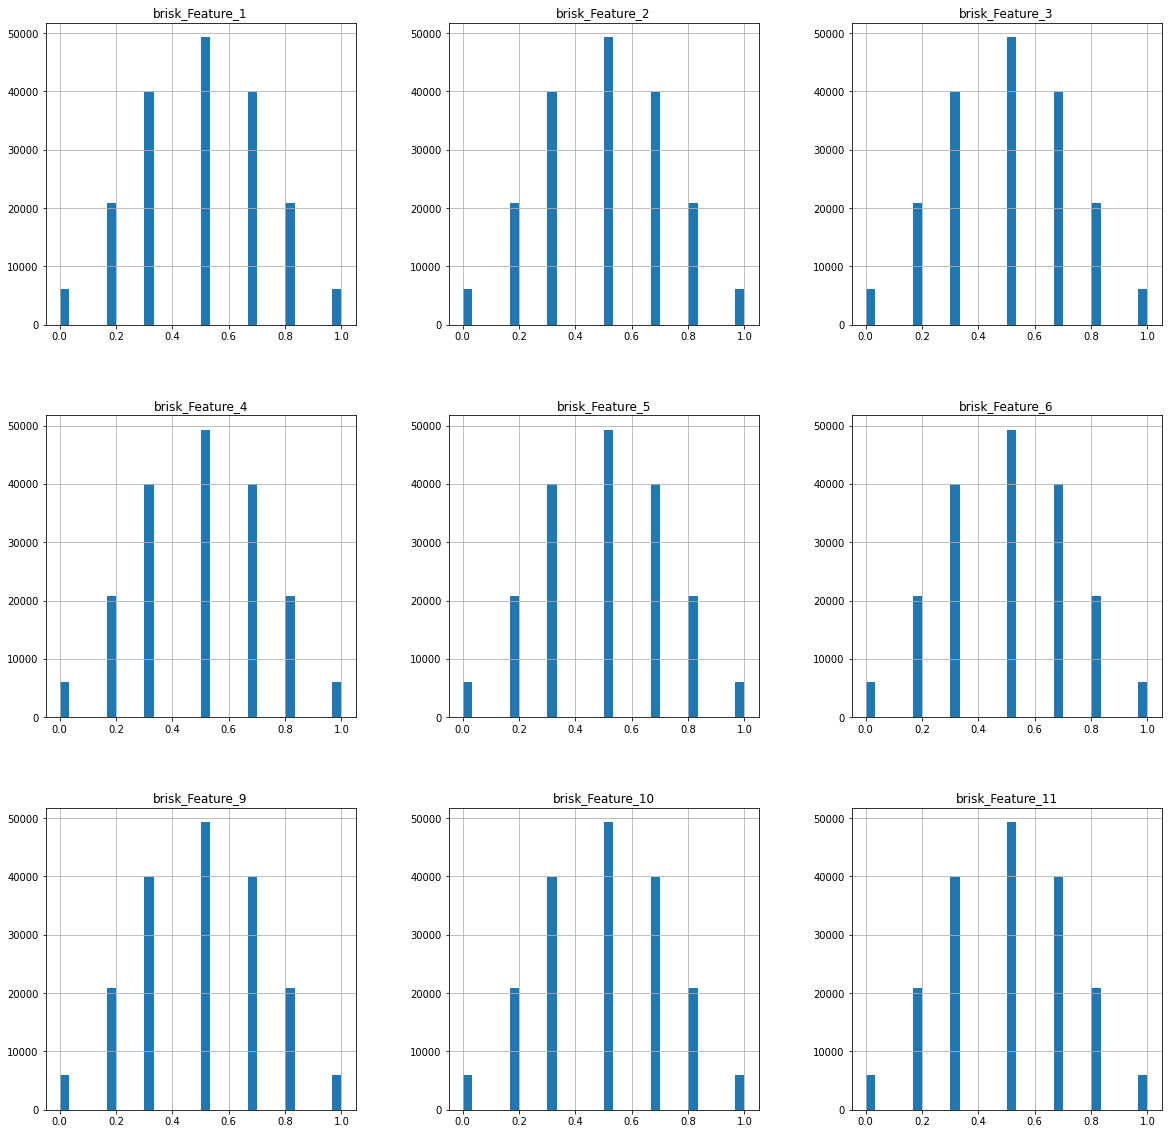

In [18]:
# Train data binning explained and plot
hist = train_data[features].iloc[:, :9].hist(bins=30, figsize=(20,20))

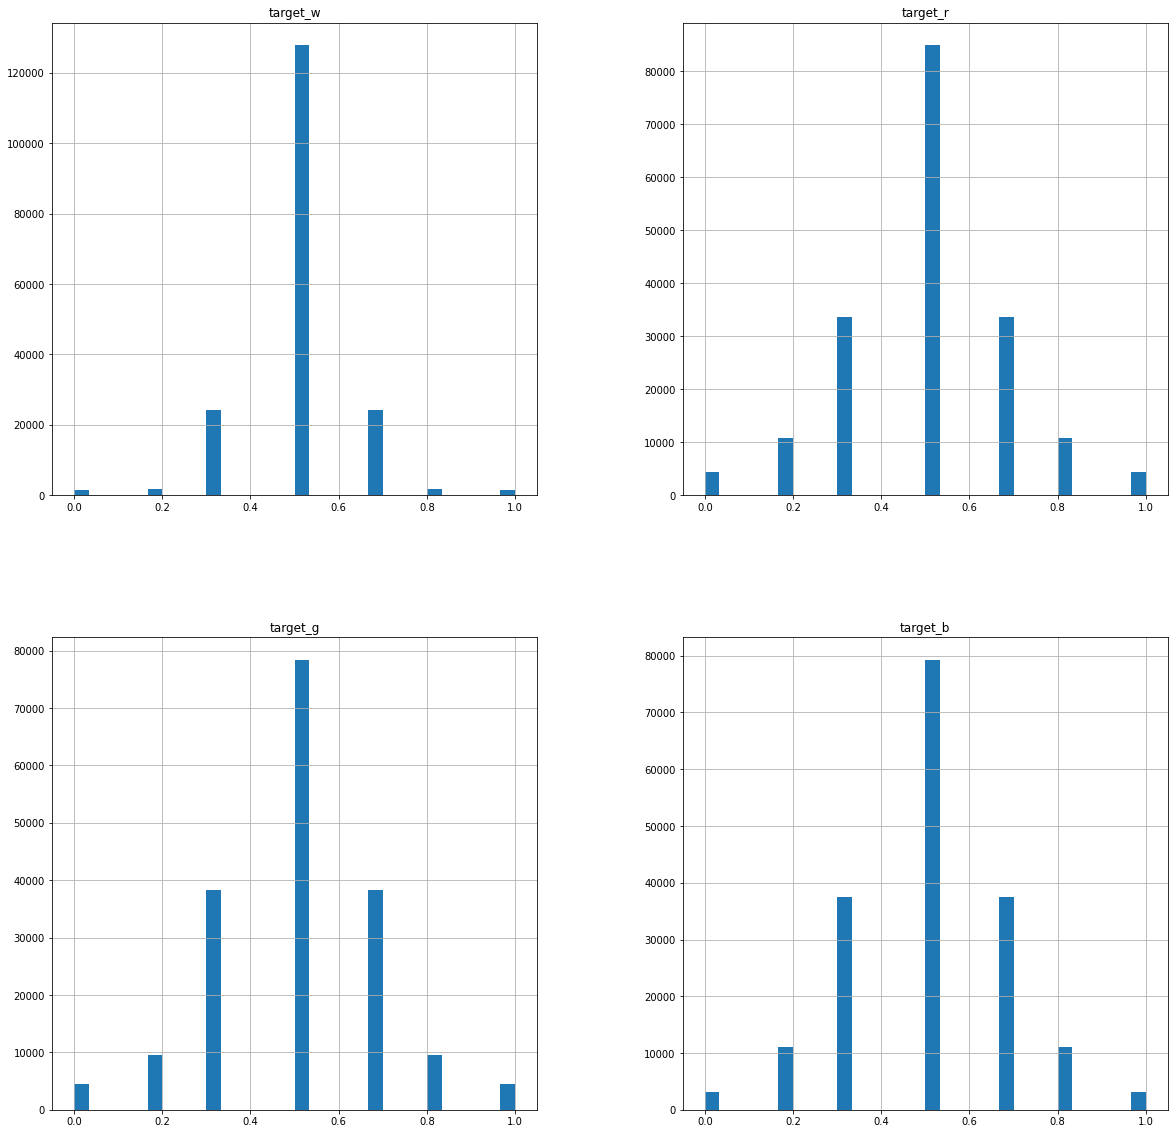

In [19]:
# Target explained and plot
hist = train_data[targets].hist(bins=30, figsize=(20,20))

## 2.3 - Number of stocks overtime

<AxesSubplot:xlabel='Moons'>

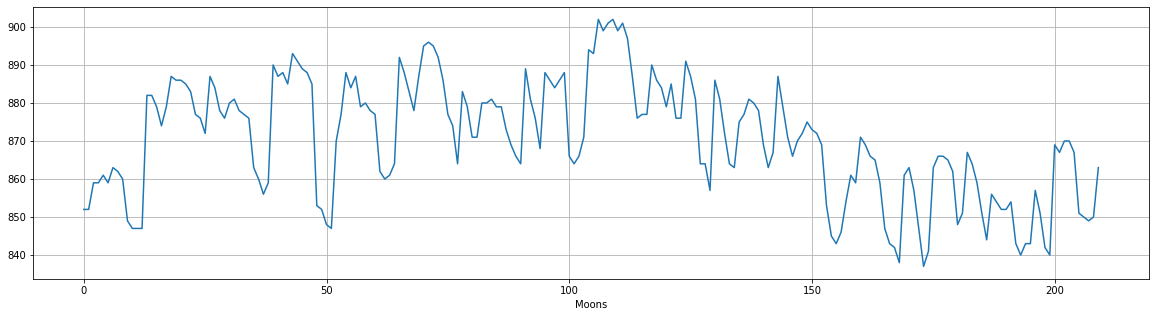

In [20]:
# Show the number of stocks in each moon 
train_data.groupby('Moons', group_keys=False).id.count().plot(figsize=(20, 5), grid='on')

# 3 - Model

In [41]:
# # insttal catboost
# !pip install catboost

In [50]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import GradientBoostingRegressor

def xg_boost_template(X_train, y_train, X_test, y_test, test_refs, target):
    model = xgb.XGBRegressor(objective='reg:squarederror', max_depth=3, learning_rate=0.01, n_estimators=200, n_jobs=-1, colsample_bytree=0.5)
    model.fit(X_train, y_train[target], verbose=True)

    # Test the spearman of your model on the X_test data
    preds = pd.DataFrame(model.predict(X_test), columns=[target])
    get_spearman_results(preds, y_test, test_refs)

    return model

def gbr(X_train, y_train, X_test, y_test, test_refs, target):
    model = GradientBoostingRegressor()
    model.fit(X_train, y_train[target])

    # Test the spearman of your model on the X_test data
    preds = pd.DataFrame(model.predict(X_test), columns=[target])
    get_spearman_results(preds, y_test, test_refs)
    return model

# 4 - Scoring: Spearman's rank correlation of your predictions vs the targets

In [51]:
def get_spearman_results(preds, y_test, test_refs):
    preds.rename({f'{target}':f'pred_{target.split("_")[1]}' for target in preds.columns}, axis=1, inplace=True)
    preds_ref = pd.concat([preds.reset_index(drop=True), test_refs.reset_index(drop=True), y_test.reset_index(drop=True)], axis=1)
    spearman = pd.DataFrame()
    
    target_suffixes = [col.split('_')[-1] for col in preds.columns if 'pred' in col]
    for suffix in target_suffixes:
        spearman[f'target_{suffix}'] = preds_ref.groupby('Moons')[[f'pred_{suffix}', f'target_{suffix}']].corr(method='spearman').unstack().iloc[:,1]

    print(f'\nSpearman score over the period :\n{spearman.describe()}\n')
    return spearman

# 5 - Embargoed Train / Test split

In [52]:
def train_test_split(data):
    number_of_moons = len(data['Moons'].unique())
    embargo = 13 # Embargo between train and test set
    proportion = 0.8

    # Train on 80% of the first moons and test on 20% of the last moons
    train_set = data[data['Moons'] < int(number_of_moons * proportion) - embargo]
    test_set = data[data['Moons'] > int(number_of_moons * proportion)]

    X_train = train_set[features]
    y_train = train_set[targets]
    X_test = test_set[features]
    y_test = test_set[targets]
    test_refs = test_set.iloc[:, :2]

    return X_train, y_train, X_test, y_test, test_refs

# Supervised training of a simple XGBoost

In [53]:
# Split your data to test your model
X_train, y_train, X_test, y_test, test_refs = train_test_split(train_data)

In [ ]:
# Run your model on the different targets
model = {}
for target in targets:
  model[f'gbr_model_{target}'] = gbr(X_train, y_train, X_test, y_test, test_refs, target)

# 6 - Make prediction on the 4 targets

When you feel like your model is accurate enough it's time to predict the target and submit your results.

Predict on the 4 targets, concatenate the answers and submit.

**WARNING** 1/ Be sure that your columns are named id, Moons, target_w, target_r, etc

**WARNING** 2/ Your prediction need to be between 0 and 1.

**WARNING** 3/ Don't submit constant values.

**WARNING** 4/ Submit the id and the moon columns.

In [ ]:
prediction = test_data.iloc[:, :2]
for target in targets:
    prediction.loc[:, target] = model[f'xgb_model_{target}'].predict(test_data.iloc[:, 2:])

**Check your submission file**

In [ ]:
prediction

In [ ]:
# Check the validity of your prediction dataframe

for moon in prediction['Moons'].unique():
    # Check if you have the same id than in the example_submission
    if not set(prediction[prediction['Moons'] == moon]['id'].unique()) == set(exemple_submission[exemple_submission['Moons'] == moon]['id'].unique()):
        print('Your dataframe does not contain the ids required for each moon')
    for target in targets:
        # Check if you have constants for each moon and each target
        if prediction[prediction['Moons'] == moon][target].nunique() == 1:
            print(f'Your submission contains constant values on moon : {moon}')

# Check if your columns are well named
if prediction.columns.tolist() != exemple_submission.columns.tolist():
    print('Your columns name does not match the exemple_submission columns')

# Check if your values are between 0 and 1
if (prediction.iloc[:, 2:].values > 1).any() or (prediction.iloc[:, 2:].values < 0).any():
    print('At least one value is higher than 1 or lower than 0')

# 7 - Submit predictions

Past <u>your</u> API key here. You received it by email upon registration and can retrieve it in your dashboard.

In [ ]:
API_KEY = "" # <- enter your API key HERE

r = requests.post("https://tournament.crunchdao.com/api/v2/submissions",
    files = {
        "file": ("x", prediction.to_csv().encode('ascii'))
    },
    data = {
        "apiKey": API_KEY, 
        "comment": 'My xgboost model', # <- Enter your comment here
        # "model": '', # Coming soon...
    },
)

if r.status_code == 200:
    print("Submission submitted.")
elif r.status_code == 423:
    print("ERR: Submissions are close")
    print("You can only submit during rounds eg: Friday 7pm GMT+1 to Sunday midnight GMT+1.")
    print("Or the server is currently crunching the submitted files, please wait some time before retrying.")
elif r.status_code == 422:
    print("ERR: API Key is missing or empty")
    print("Did you forget to fill the API_KEY variable?")
elif r.status_code == 400:
    print("ERR: The file must not be empty")
    print("You have send a empty file.")
elif r.status_code == 401:
    print("ERR: Your email hasn't been verified")
    print("Please verify your email or contact a cruncher.")
elif r.status_code == 409:
    print("ERR: Duplicate submission")
    print("Your work has already been submitted with the same exact results, if you think that this a false positive, contact a cruncher.")
    print("MD5 collision probability: 1/2^128 (source: https://stackoverflow.com/a/288519/7292958)")
elif r.status_code == 429:
    print("ERR: Too many submissions")
else:
    print("ERR: Server returned: " + str(r.status_code))
    print("Ouch! It seems that we were not expecting this kind of result from the server, if the probleme persist, contact a cruncher.")

In [ ]:
# Downloads your prediction file
from google.colab import files
with open("prediciton.csv", "wb") as f:
    f.write(prediction.to_csv().encode('ascii'))
files.download('prediciton.csv')

# Useful links

**Website**

- https://tournament.crunchdao.com/

**Social media**
- discord : https://discord.gg/9wvzxS7A (come say hi! ;) )
- twitter : https://twitter.com/CrunchDAO
- linkedin : https://www.linkedin.com/company/crunchdao-com/
- reddit : https://www.reddit.com/r/crunchdao/

**Documentation**

- https://app.gitbook.com/o/RB633hrgkrGuKJC9yruJ/s/-MlFOs6xmgr7kZX4EBUW/tournament/getting-started

**Github**

- https://github.com/crunchdao/

**DeSci - research framework**

- https://desci.crunchdao.com/projects/crunchdao